# TIDY TUESDAY MEETS D&D

I don't know anything about Dungeons and Dragons. I've thought it would be cool to play someday, but it also seems incredibly overwhelming to get started. This data set was perhaps a good metaphor for this feeling. Lots of related variables, no idea where to begin, just kind of flailed around trying to find something notable. It's tough when you're not really sure what you're looking for in a data set. In these cases, I generally try to think about how I could use the data to learn about models or tools. I started with clustering, but then quickly went to looking at how OLS compares to more complex models. OLS did surprisingly well despite all of the colinearity in the data. The xgboost results are almost certainly overfit--they are actually perfectly fit--but it's interesting to see how well the model did given that this is the workhorse of every Kaggle competition (and clearly for a reason).

In [51]:
import polars as pl # for data tidying
from polars.selectors import numeric, string # for filtering
import seaborn as sns # for viz
import numpy as np # because this is python and you must import numpy or else
import random # for setting the seed
from scipy.stats import pearsonr # for correlations
import matplotlib.pyplot as plt # viz stuff
from sklearn.preprocessing import StandardScaler # for standardizing the data
from sklearn.decomposition import PCA # PCA is for PCA, go figure
from sklearn.cluster import KMeans # basic b clustering
import matplotlib.pyplot as plt # for some more plotting
import pymc as pm # for modeling
from pymc_bart import BART # for bart model
import pymc_bart as pmb # for basic part viz
import arviz as az # for posterior analysis and some plotting
import hdbscan # for more intense clustering
import xgboost as xgb # classico
import statsmodels.api as sm # ols
from sklearn.model_selection import train_test_split # for testing training splitting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # model metrics

# set seed
random.seed(5272025)

monsters = pl.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-27/monsters.csv', try_parse_dates= True)


In [52]:
# Positron has some nice built in viewing features, but just to kick the tires on Polars, let's do a little EDA

monsters.describe()


shape: (9, 34)
┌────────────┬─────────┬──────────┬──────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ statistic  ┆ name    ┆ category ┆ cr       ┆ … ┆ gear       ┆ senses     ┆ languages ┆ full_text │
│ ---        ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│ str        ┆ str     ┆ str      ┆ f64      ┆   ┆ str        ┆ str        ┆ str       ┆ str       │
╞════════════╪═════════╪══════════╪══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ count      ┆ 330     ┆ 330      ┆ 330.0    ┆ … ┆ 330        ┆ 330        ┆ 330       ┆ 330       │
│ null_count ┆ 0       ┆ 0        ┆ 0.0      ┆ … ┆ 0          ┆ 0          ┆ 0         ┆ 0         │
│ mean       ┆ null    ┆ null     ┆ 4.551136 ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ std        ┆ null    ┆ null     ┆ 5.797444 ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ min        ┆ Aboleth ┆ Aboleth  ┆ 0.0      ┆ … ┆ Battleaxe, ┆ Blindsight ┆ Abyssal   ┆ Aboleth   │
│            ┆         ┆          ┆          ┆   ┆ Morningsta ┆ 10 ft.,    ┆           ┆ Large Abe │
│            ┆         ┆          ┆          ┆   ┆ r          ┆ Darkvision ┆           ┆ rration,  │
│            ┆         ┆          ┆          ┆   ┆            ┆ …          ┆           ┆ Lawf…     │
│ 25%        ┆ null    ┆ null     ┆ 0.5      ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ 50%        ┆ null    ┆ null     ┆ 2.0      ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ 75%        ┆ null    ┆ null     ┆ 6.0      ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ max        ┆ Zombie  ┆ Zombies  ┆ 30.0     ┆ … ┆ Wand       ┆ Truesight  ┆ Understan ┆ Zombie    │
│            ┆         ┆          ┆          ┆   ┆            ┆ 60 ft.;    ┆ ds        ┆ Medium    │
│            ┆         ┆          ┆          ┆   ┆            ┆ Passive    ┆ commands  ┆ Undead,   │
│            ┆         ┆          ┆          ┆   ┆            ┆ Perc…      ┆ given in  ┆ Neutral … │
│            ┆         ┆          ┆          ┆   ┆            ┆            ┆ …         ┆           │
└────────────┴─────────┴──────────┴──────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [53]:
# HP number has a larger standard deviation than mean, which is kind of interesting. Let's see what we can see with that
monsters.group_by("category").agg([
    pl.col("hp_number").mean().alias("mean"),
    pl.col("hp_number").std().alias("std"),
    pl.col("hp_number").min().alias("min"),
    pl.col("hp_number").max().alias("max"),
    pl.col("hp_number").median().alias("median"),
    pl.col("hp_number").quantile(0.25).alias("q25"),
    pl.col("hp_number").quantile(0.75).alias("q75"),
    pl.col("hp_number").count().alias("n")
])

# earth elementals have the highest average hit points

shape: (178, 9)
┌─────────────────┬───────────┬───────────┬─────┬───┬────────┬───────┬───────┬─────┐
│ category        ┆ mean      ┆ std       ┆ min ┆ … ┆ median ┆ q25   ┆ q75   ┆ n   │
│ ---             ┆ ---       ┆ ---       ┆ --- ┆   ┆ ---    ┆ ---   ┆ ---   ┆ --- │
│ str             ┆ f64       ┆ f64       ┆ i64 ┆   ┆ f64    ┆ f64   ┆ f64   ┆ u32 │
╞═════════════════╪═══════════╪═══════════╪═════╪═══╪════════╪═══════╪═══════╪═════╡
│ Assassin        ┆ 97.0      ┆ null      ┆ 97  ┆ … ┆ 97.0   ┆ 97.0  ┆ 97.0  ┆ 1   │
│ Stone Golem     ┆ 220.0     ┆ null      ┆ 220 ┆ … ┆ 220.0  ┆ 220.0 ┆ 220.0 ┆ 1   │
│ Gray Ooze       ┆ 22.0      ┆ null      ┆ 22  ┆ … ┆ 22.0   ┆ 22.0  ┆ 22.0  ┆ 1   │
│ Animals         ┆ 27.063158 ┆ 32.739725 ┆ 1   ┆ … ┆ 15.0   ┆ 5.0   ┆ 39.0  ┆ 95  │
│ Wyvern          ┆ 127.0     ┆ null      ┆ 127 ┆ … ┆ 127.0  ┆ 127.0 ┆ 127.0 ┆ 1   │
│ …               ┆ …         ┆ …         ┆ …   ┆ … ┆ …      ┆ …     ┆ …     ┆ …   │
│ Toughs          ┆ 57.0      ┆ 35.355339 ┆ 32  ┆ … ┆ 57.0   ┆ 32.0  ┆ 82.0  ┆ 2   │
│ Ghost           ┆ 45.0      ┆ null      ┆ 45  ┆ … ┆ 45.0   ┆ 45.0  ┆ 45.0  ┆ 1   │
│ Skeletons       ┆ 26.666667 ┆ 16.502525 ┆ 13  ┆ … ┆ 22.0   ┆ 22.0  ┆ 45.0  ┆ 3   │
│ Warriors        ┆ 37.0      ┆ 39.59798  ┆ 9   ┆ … ┆ 37.0   ┆ 9.0   ┆ 65.0  ┆ 2   │
│ Shield Guardian ┆ 142.0     ┆ null      ┆ 142 ┆ … ┆ 142.0  ┆ 142.0 ┆ 142.0 ┆ 1   │
└─────────────────┴───────────┴───────────┴─────┴───┴────────┴───────┴───────┴─────┘

In [54]:
# let's also look at hp by size
monsters.group_by("size").agg([
    pl.col("hp_number").mean().alias("mean"),
    pl.col("hp_number").std().alias("std"),
    pl.col("hp_number").min().alias("min"),
    pl.col("hp_number").max().alias("max"),
    pl.col("hp_number").median().alias("median"),
    pl.col("hp_number").quantile(0.25).alias("q25"),
    pl.col("hp_number").quantile(0.75).alias("q75"),
    pl.col("hp_number").count().alias("n")
])

shape: (7, 9)
┌─────────────────┬────────────┬────────────┬─────┬───┬────────┬───────┬───────┬─────┐
│ size            ┆ mean       ┆ std        ┆ min ┆ … ┆ median ┆ q25   ┆ q75   ┆ n   │
│ ---             ┆ ---        ┆ ---        ┆ --- ┆   ┆ ---    ┆ ---   ┆ ---   ┆ --- │
│ str             ┆ f64        ┆ f64        ┆ i64 ┆   ┆ f64    ┆ f64   ┆ f64   ┆ u32 │
╞═════════════════╪════════════╪════════════╪═════╪═══╪════════╪═══════╪═══════╪═════╡
│ Huge            ┆ 154.323529 ┆ 63.292836  ┆ 42  ┆ … ┆ 165.0  ┆ 92.0  ┆ 200.0 ┆ 34  │
│ Tiny            ┆ 6.4        ┆ 8.401389   ┆ 1   ┆ … ┆ 2.0    ┆ 1.0   ┆ 5.0   ┆ 25  │
│ Medium or Small ┆ 66.111111  ┆ 49.707589  ┆ 4   ┆ … ┆ 62.5   ┆ 32.0  ┆ 84.0  ┆ 36  │
│ Small           ┆ 11.782609  ┆ 6.673942   ┆ 3   ┆ … ┆ 10.0   ┆ 7.0   ┆ 18.0  ┆ 23  │
│ Large           ┆ 94.271028  ┆ 70.016113  ┆ 11  ┆ … ┆ 85.0   ┆ 42.0  ┆ 136.0 ┆ 107 │
│ Gargantuan      ┆ 418.4      ┆ 118.116649 ┆ 247 ┆ … ┆ 402.0  ┆ 356.0 ┆ 481.0 ┆ 15  │
│ Medium          ┆ 46.444444  ┆ 51.128855  ┆ 4   ┆ … ┆ 32.5   ┆ 14.0  ┆ 58.0  ┆ 90  │
└─────────────────┴────────────┴────────────┴─────┴───┴────────┴───────┴───────┴─────┘

In [55]:
# Get mean hp_number for size == "Medium"
# there has to be a better way to do this within a polars chunk
medium_hp_mean = (
    monsters.filter(pl.col("size") == "Medium")
            .select(pl.mean("hp_number"))
            .item()
)

# Recode "Medium or Small" based on hp_number threshold

monsters = monsters.with_columns(
    pl.when((pl.col("size") == "Medium or Small") & (pl.col("hp_number") >= medium_hp_mean))
      .then(pl.lit("Medium"))
      .when((pl.col("size") == "Medium or Small") & (pl.col("hp_number") < medium_hp_mean))
      .then(pl.lit("Small"))
      .otherwise(pl.col('size'))
      .alias("size_cleaned")
)


monsters.group_by("size_cleaned").agg([
    pl.col("hp_number").mean().alias("mean"),
    pl.col("hp_number").std().alias("std"),
    pl.col("hp_number").min().alias("min"),
    pl.col("hp_number").max().alias("max"),
    pl.col("hp_number").median().alias("median"),
    pl.col("hp_number").quantile(0.25).alias("q25"),
    pl.col("hp_number").quantile(0.75).alias("q75"),
    pl.col("hp_number").count().alias("n")
])





shape: (6, 9)
┌──────────────┬────────────┬────────────┬─────┬───┬────────┬───────┬───────┬─────┐
│ size_cleaned ┆ mean       ┆ std        ┆ min ┆ … ┆ median ┆ q25   ┆ q75   ┆ n   │
│ ---          ┆ ---        ┆ ---        ┆ --- ┆   ┆ ---    ┆ ---   ┆ ---   ┆ --- │
│ str          ┆ f64        ┆ f64        ┆ i64 ┆   ┆ f64    ┆ f64   ┆ f64   ┆ u32 │
╞══════════════╪════════════╪════════════╪═════╪═══╪════════╪═══════╪═══════╪═════╡
│ Small        ┆ 15.378378  ┆ 11.12892   ┆ 3   ┆ … ┆ 11.0   ┆ 7.0   ┆ 21.0  ┆ 37  │
│ Gargantuan   ┆ 418.4      ┆ 118.116649 ┆ 247 ┆ … ┆ 402.0  ┆ 356.0 ┆ 481.0 ┆ 15  │
│ Large        ┆ 94.271028  ┆ 70.016113  ┆ 11  ┆ … ┆ 85.0   ┆ 42.0  ┆ 136.0 ┆ 107 │
│ Tiny         ┆ 6.4        ┆ 8.401389   ┆ 1   ┆ … ┆ 2.0    ┆ 1.0   ┆ 5.0   ┆ 25  │
│ Medium       ┆ 55.910714  ┆ 52.972295  ┆ 4   ┆ … ┆ 41.5   ┆ 19.0  ┆ 71.0  ┆ 112 │
│ Huge         ┆ 154.323529 ┆ 63.292836  ┆ 42  ┆ … ┆ 165.0  ┆ 92.0  ┆ 200.0 ┆ 34  │
└──────────────┴────────────┴────────────┴─────┴───┴────────┴───────┴───────┴─────┘

/Applications/Positron.app/Contents/Resources/app/extensions/positron-python/python_files/lib/ipykernel/py3/IPython/core/pylabtools.py:152: UserWarning: Glyph 961 (\N{GREEK SMALL LETTER RHO}) missing from font(s) Gill Sans.
  fig.canvas.print_figure(bytes_io, **kw)


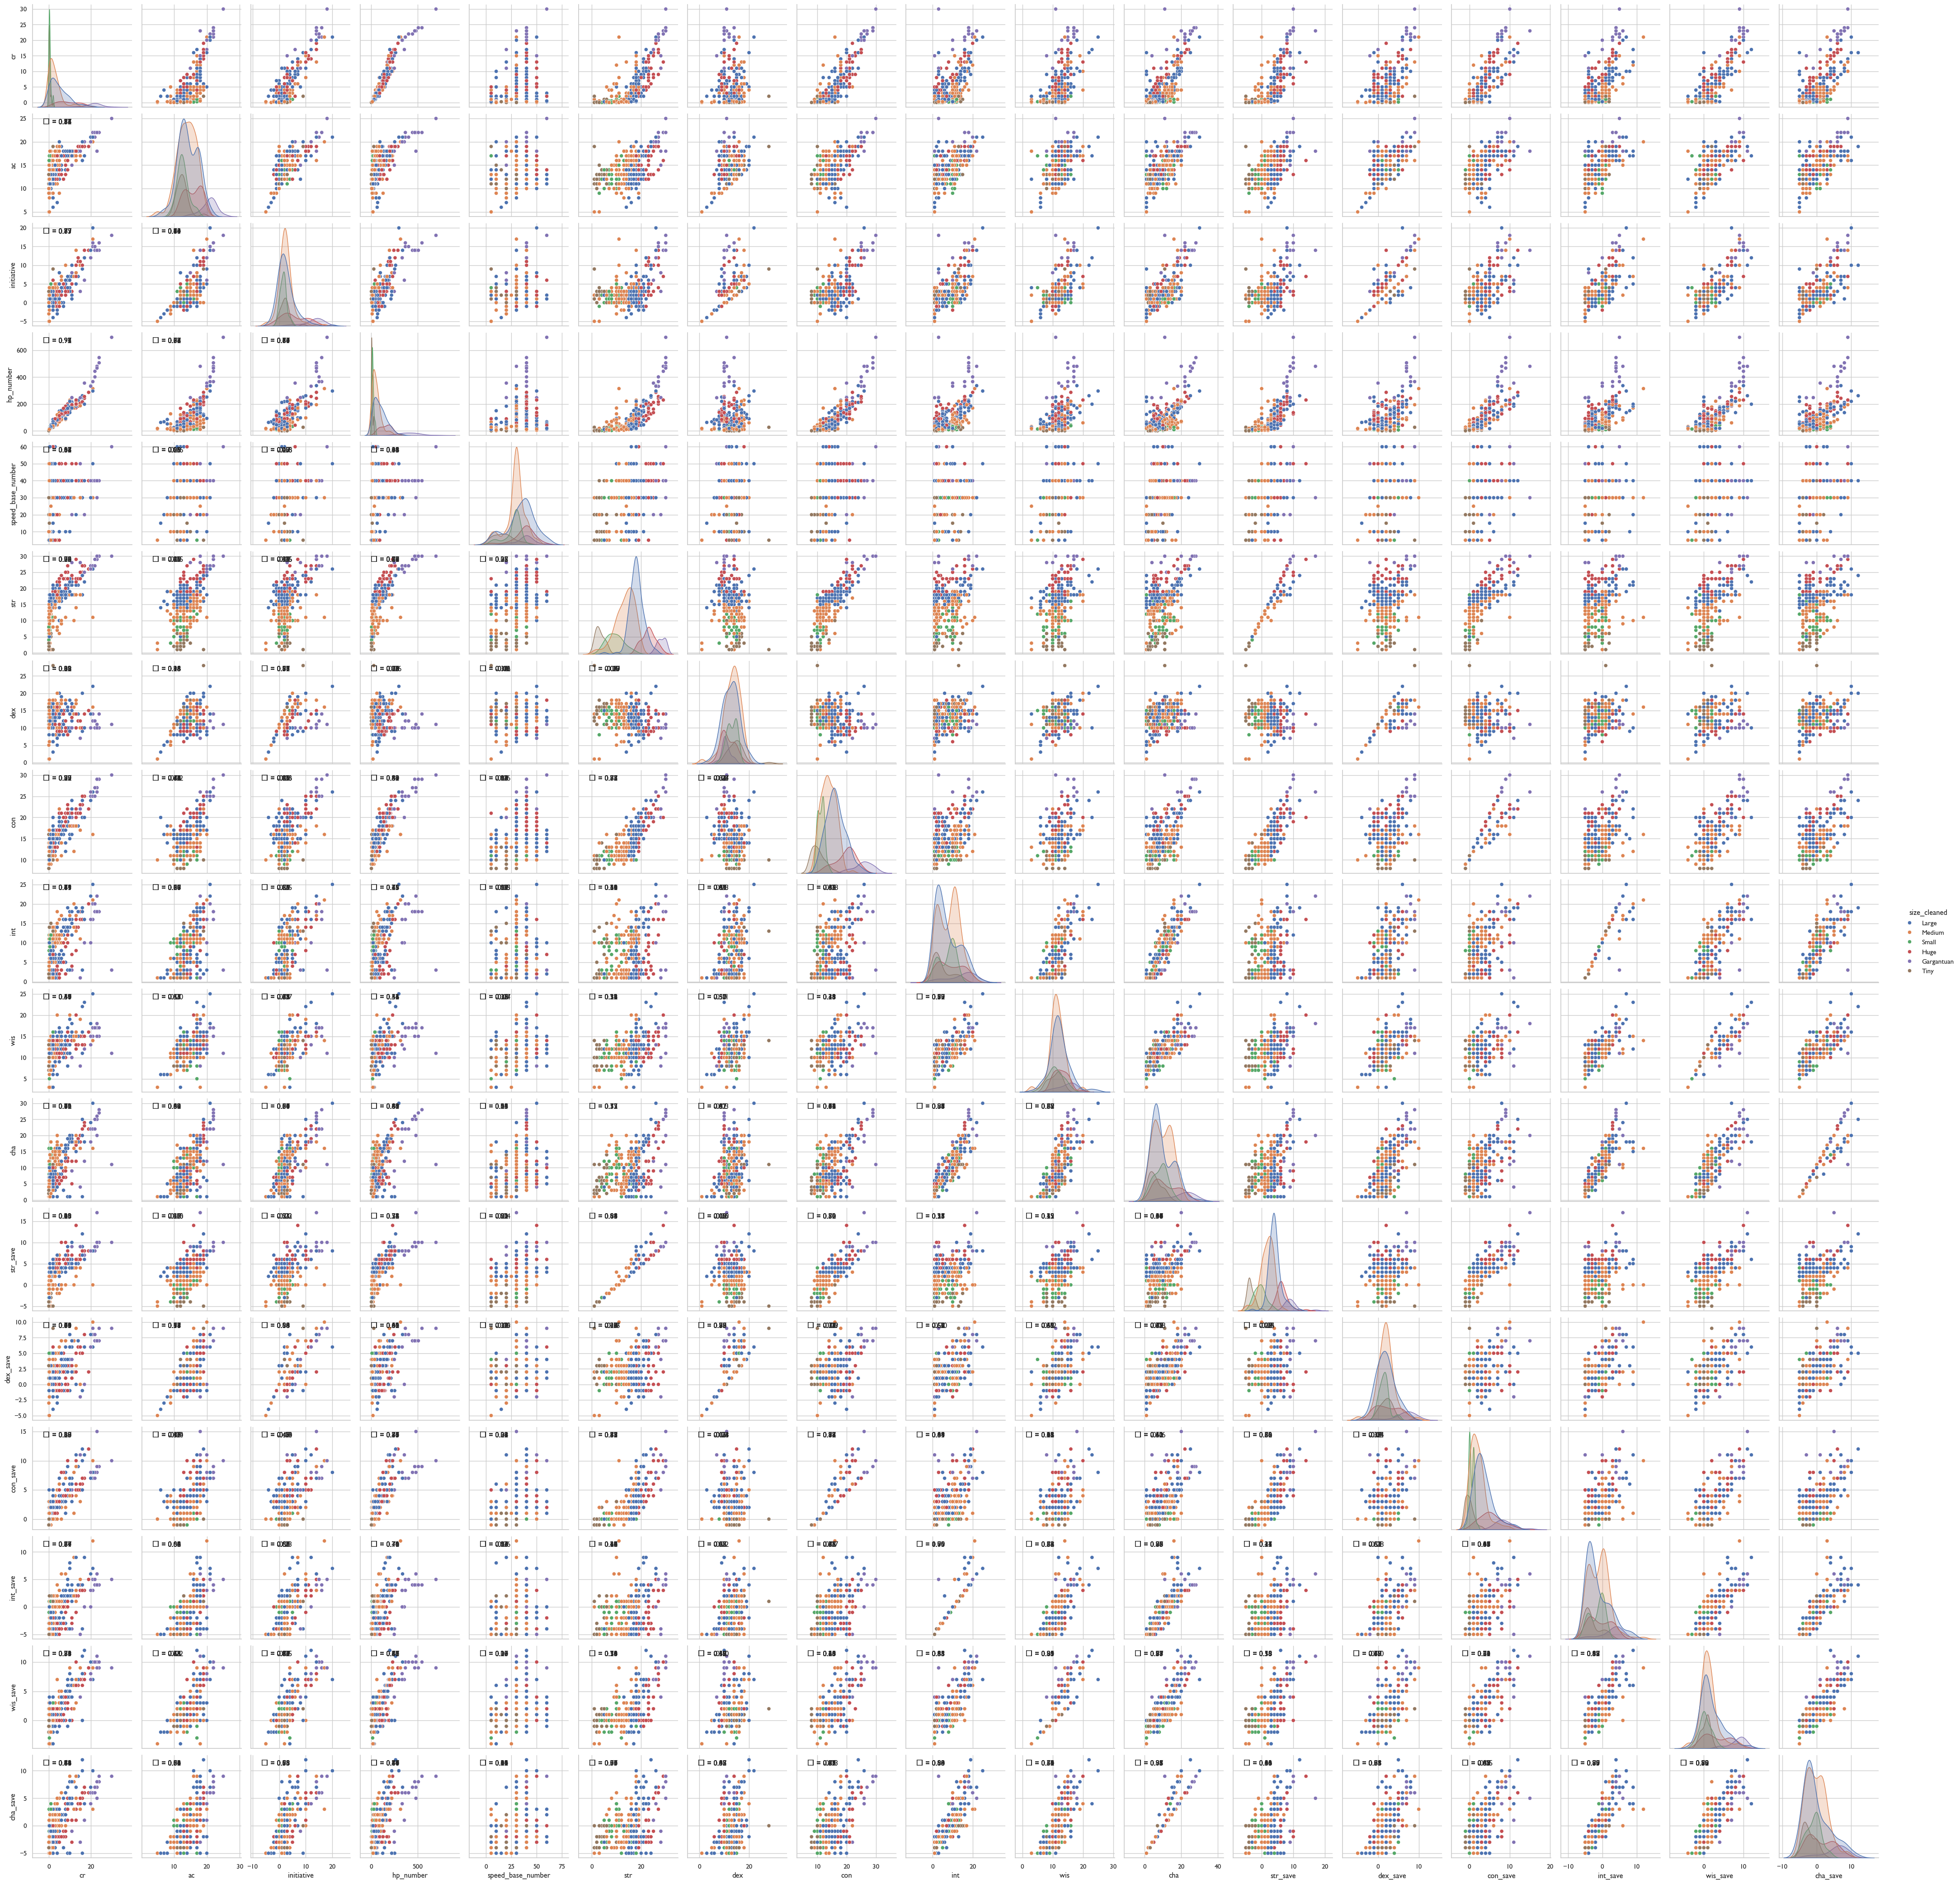

In [56]:
# add in correlations to pairplot
# this is taken from https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

p = sns.pairplot(monsters.to_pandas(), hue = "size_cleaned")
p.map_lower(corrfunc)
plt.show()


It looks like we have a few highly correlated variables. This could be a good chance to do something unsupervised or black box-y.

In [57]:
# let's start with some clustering

# we'll one hot encode size_cleaned for our model
# let's create a copy of size_cleaned too
monsters = monsters.with_columns(pl.col('size_cleaned').alias('clean_size'))
monsters = monsters.to_dummies("size_cleaned")

# split up our numeric and strings
numeric_cols = monsters.select(numeric()).columns
string_cols = monsters.select(string()).columns

# drop NAs
monsters_clean = monsters.select(numeric_cols + string_cols).drop_nulls(subset=numeric_cols)

# One-liner for encoding
monsters_encoded = monsters_clean.to_dummies()

# re-scale the numerics for modeling
X_matrix = monsters_encoded.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_matrix)

# cluster based on k-means, going to do five clusters
kmeans = KMeans(n_clusters=5, random_state=5272025)
labels = kmeans.fit_predict(X_scaled)

# do a lil PCA to group
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_scaled)

# add the clusters back into the monsters data
monsters_result = monsters_clean.with_columns([
    pl.Series("cluster", labels),
    pl.Series("pca1", X_pca[:, 0]),
    pl.Series("pca2", X_pca[:, 1])
])

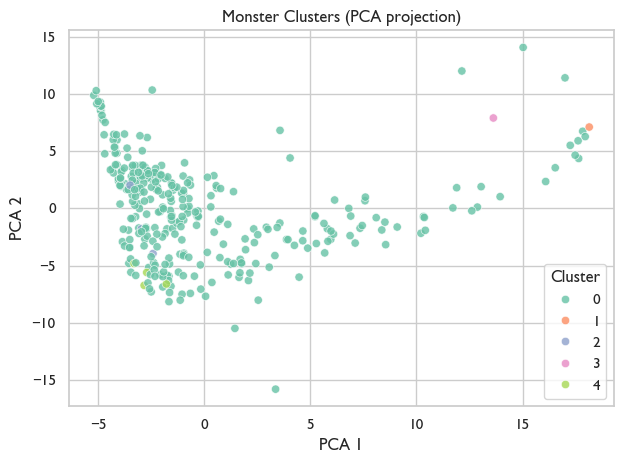

In [58]:
# Convert to minimal data frame for plotting
plot_df = monsters_result.select(["pca1", "pca2", "cluster"]).to_pandas()

sns.scatterplot(data=plot_df, x="pca1", y="pca2", hue="cluster", palette="Set2", alpha=0.8)
plt.title("Monster Clusters (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


There is probably more I could do on this clustering approach, but the above doesn't give me the sense that there's much there there. In general, I'd hope to see some natural clustering, but perhaps because of the encoding or perhaps because of the overlap in features, k-means + PCA isn't cutting it. Let's turn to a model!


In [59]:
# Since I want to get at some sort of latent structure
# but honestly don't know much about the data and it seems like
# there are a lot of both linear, and likely non-linear, relationships
# let's turn to a more tree-based method. xgboost would be an obvious choice but
# I'm not quite sure I have a clear supervised ask of the model (there are ways around this using permutation, but still)
# so let's try out BART, which is a little more flexible and gives a nice measure of uncertainty

# prepare data
# this is basically what we did above
numeric_cols = monsters.select(numeric()).columns
df = monsters.select(numeric_cols).drop_nulls()

# we're going to see how everything relates to hp_number, which was our higher
# variance metric from descriptive analysis
target = "hp_number"
# just create a vector of our Xs
features = df.drop("hp_number")

# right hand side
X = df.select(features).to_numpy()
# left hand side
y = df.select(target).to_numpy().ravel()

# Standardize Now!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# model fitting
# more info on pymc's docs, including how to get the greek: https://www.pymc.io/projects/bart/en/latest/examples/bart_introduction.html
with pm.Model() as model:
    μ = BART("μ", X=X_scaled, Y=y)
    σ = pm.HalfNormal("σ", sigma=1)
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=y)

    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.95, random_seed=5272025)


                                                                                                           
  Progress            Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━   0       0             0.00        0            0.00 draws/s     0:00:00   -:--:--    
  ━━━━━━━━━━━━━━━━━   0       0             0.00        0            0.00 draws/s     0:00:00   -:--:--    
                                                                                                           
  Progress            Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━   0       0             0.00        0            0.00 draws/s     0:00:00   -:--:--    
  ━━━━━━━━━━━━━━━━━   0     

In [60]:
# posterior predictive mean and std across draws
posterior_samples = trace.posterior["μ"].stack(sample=("chain", "draw")).values


posterior_mean = posterior_samples.mean(axis=1)  
posterior_std = posterior_samples.std(axis=1)
pca_coords = PCA(n_components=2).fit_transform(posterior_samples)

monsters_result = df.with_columns([
    pl.Series("bart_pred", posterior_mean),
    pl.Series("bart_std", posterior_std),
    pl.Series("pca1", pca_coords[:, 0]),
    pl.Series("pca2", pca_coords[:, 1])
])

monsters = monsters.with_row_index("row_id")
monsters_result = monsters_result.with_row_index("row_id")

monsters_combined = monsters.join(
    monsters_result
    , on="row_id",
    how="left"
)

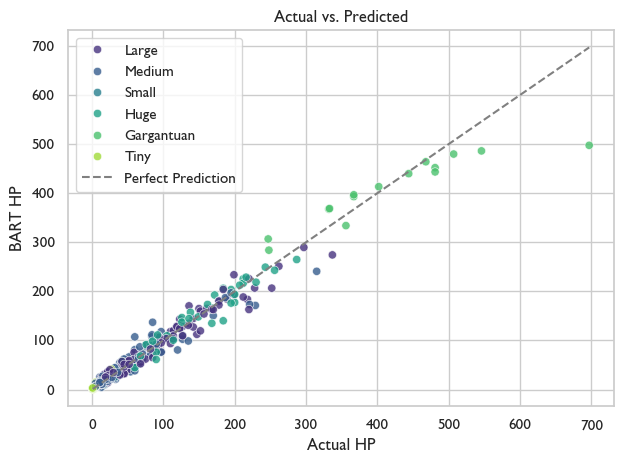

In [61]:
sns.scatterplot(data=monsters_combined, x="hp_number", y="bart_pred", hue="clean_size", palette="viridis", alpha=0.8)
plt.plot([monsters_combined["hp_number"].min(), monsters_combined["hp_number"].max()],
         [monsters_combined["hp_number"].min(), monsters_combined["hp_number"].max()],
         ls="--", color="gray", label="Perfect Prediction")
plt.xlabel("Actual HP")
plt.ylabel("BART HP")
plt.title("Actual vs. Predicted")
plt.legend()
plt.tight_layout()
plt.show()

It looks like there's a bit of fit variation by size, so let's take a look at that.

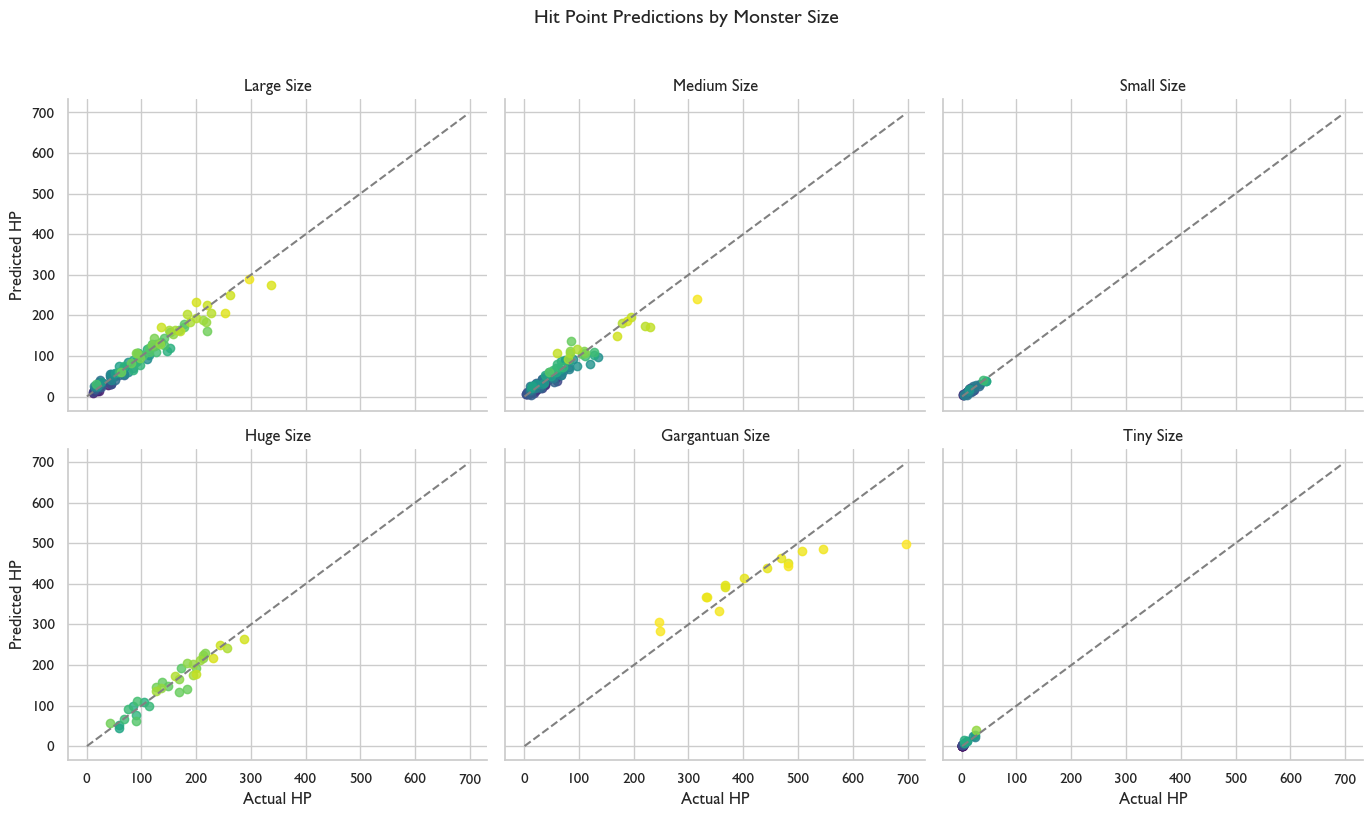

In [62]:
# create faceted plot
g = sns.lmplot(
    data=monsters_combined,
    x="hp_number", y="bart_pred",
    hue="bart_std", palette="viridis",
    col="clean_size", col_wrap=3,
    height=4, scatter_kws={"alpha": 0.8}
)

# Add 1:1 reference line--this is helpful to eyeballing model fit
for ax in g.axes.flat:
    min_val = min(monsters_combined["hp_number"].min(), monsters_combined["bart_pred"].min())
    max_val = max(monsters_combined["hp_number"].max(), monsters_combined["bart_pred"].max())
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray")

# label and whatnot
g.set_titles(col_template="{col_name} Size")
g.set_axis_labels("Actual HP", "Predicted HP")
g.fig.suptitle("Hit Point Predictions by Monster Size", y=1.02)
g._legend.remove()
plt.tight_layout()
plt.show()

Ok, not loving where this going. It seems like the model does well as long as the sample size is large, which...go figure. 

In [63]:
# Make a data frame comparing actuals and predicted values
monsters_resid_df = monsters_combined.with_columns([
    (pl.col("hp_number") - pl.col("bart_pred")).alias("residual"),
    ((pl.col("hp_number") - pl.col("bart_pred")) / pl.col("hp_number")).alias("relative_error")
])

# print that
monsters_resid_df.group_by("clean_size").agg([
    pl.mean("residual").alias("mean_residual"),
    pl.mean("relative_error").alias("mean_relative_error"),
    pl.std("residual").alias("std_residual"),
    pl.count().alias("n")
])

<positron-console-cell-63>:12: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)


shape: (6, 5)
┌────────────┬───────────────┬─────────────────────┬──────────────┬─────┐
│ clean_size ┆ mean_residual ┆ mean_relative_error ┆ std_residual ┆ n   │
│ ---        ┆ ---           ┆ ---                 ┆ ---          ┆ --- │
│ str        ┆ f64           ┆ f64                 ┆ f64          ┆ u32 │
╞════════════╪═══════════════╪═════════════════════╪══════════════╪═════╡
│ Small      ┆ -0.702894     ┆ -0.173172           ┆ 3.440015     ┆ 37  │
│ Large      ┆ 0.927277      ┆ -0.054064           ┆ 15.175434    ┆ 107 │
│ Gargantuan ┆ 9.921275      ┆ -0.007654           ┆ 62.39749     ┆ 15  │
│ Huge       ┆ 0.492667      ┆ -0.005387           ┆ 17.234403    ┆ 34  │
│ Medium     ┆ -0.170507     ┆ -0.111315           ┆ 16.278052    ┆ 112 │
│ Tiny       ┆ -2.232701     ┆ -0.60335            ┆ 3.479634     ┆ 25  │
└────────────┴───────────────┴─────────────────────┴──────────────┴─────┘

In [64]:
# let's dig in to the gargantuans
monsters_resid_df.filter(pl.col("clean_size") == "Gargantuan").select([
    "name", "hp_number", "bart_pred", "residual", "relative_error"
]).sort("residual")

shape: (15, 5)
┌───────────────────────┬───────────┬────────────┬────────────┬────────────────┐
│ name                  ┆ hp_number ┆ bart_pred  ┆ residual   ┆ relative_error │
│ ---                   ┆ ---       ┆ ---        ┆ ---        ┆ ---            │
│ str                   ┆ i64       ┆ f64        ┆ f64        ┆ f64            │
╞═══════════════════════╪═══════════╪════════════╪════════════╪════════════════╡
│ Purple Worm           ┆ 247       ┆ 306.803304 ┆ -59.803304 ┆ -0.242119      │
│ Roc                   ┆ 248       ┆ 283.961725 ┆ -35.961725 ┆ -0.145007      │
│ Ancient White Dragon  ┆ 333       ┆ 368.744843 ┆ -35.744843 ┆ -0.107342      │
│ Ancient Brass Dragon  ┆ 332       ┆ 367.624233 ┆ -35.624233 ┆ -0.107302      │
│ Ancient Copper Dragon ┆ 367       ┆ 396.765907 ┆ -29.765907 ┆ -0.081106      │
│ …                     ┆ …         ┆ …          ┆ …          ┆ …              │
│ Ancient Red Dragon    ┆ 507       ┆ 479.77527  ┆ 27.22473   ┆ 0.053698       │
│ Ancient Blue Dragon   ┆ 481       ┆ 452.022768 ┆ 28.977232  ┆ 0.060244       │
│ Kraken                ┆ 481       ┆ 443.35725  ┆ 37.64275   ┆ 0.078259       │
│ Ancient Gold Dragon   ┆ 546       ┆ 486.202548 ┆ 59.797452  ┆ 0.109519       │
│ Tarrasque             ┆ 697       ┆ 497.549933 ┆ 199.450067 ┆ 0.286155       │
└───────────────────────┴───────────┴────────────┴────────────┴────────────────┘

In [65]:
# Let's see how xgboost does
dtrain = xgb.DMatrix(X_scaled, label=y)
xgb_model = xgb.train({"objective": "reg:squarederror", "seed": 5272025}, dtrain, num_boost_round=100)

# Predict and attach to original df
xgb_pred = xgb_model.predict(dtrain)
monsters_combined = monsters_combined.with_columns(pl.Series("xgb_pred", xgb_pred))


In [66]:
# Ok, so now let's also toss in OLS as a gut check
# Add constant for intercept
X_with_const = sm.add_constant(X)

# Fit OLS model
ols_model = sm.OLS(y, X_with_const).fit()

# Add it in to our data frame like the others
monsters_combined = monsters_combined.with_columns([
    pl.Series("ols_pred", ols_model.predict(X_with_const)),
    pl.Series("ols_resid", y - ols_model.predict(X_with_const))
])

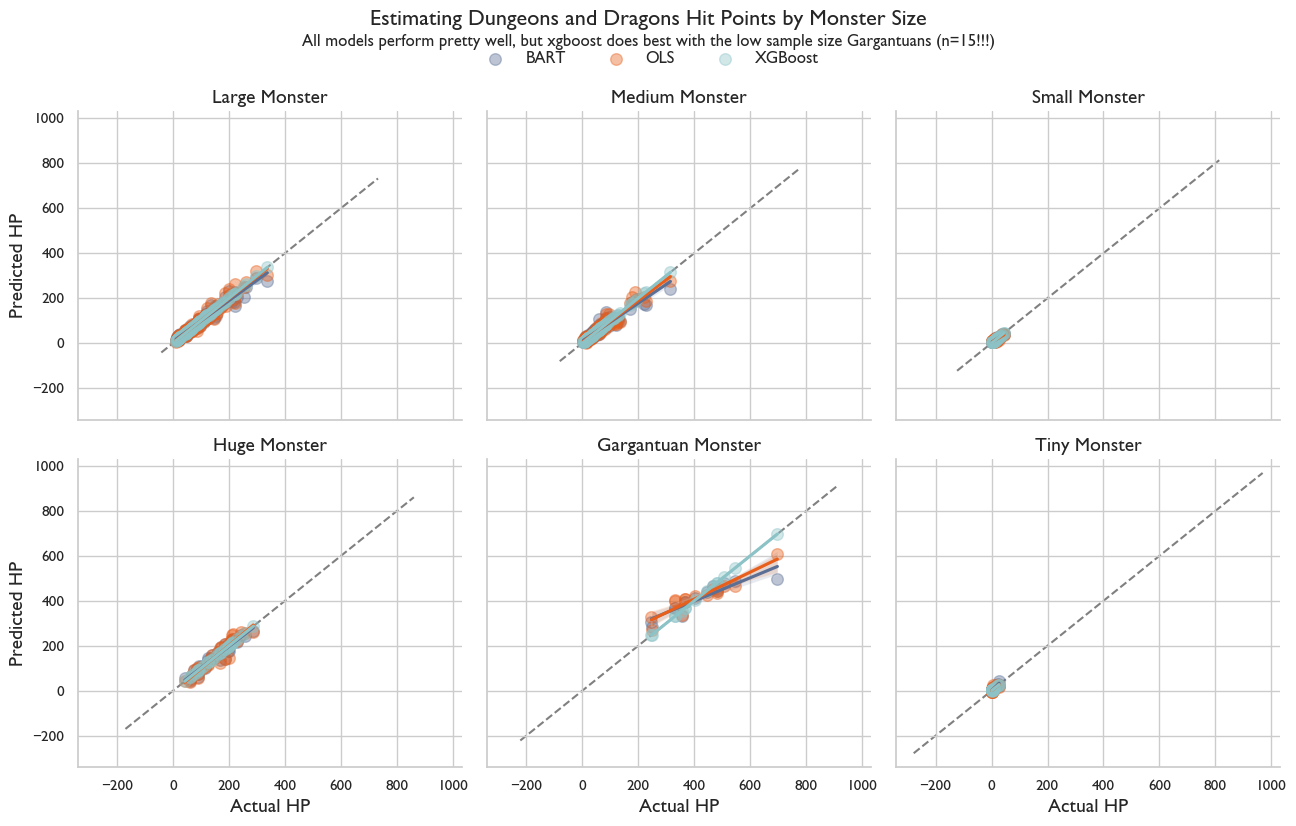

In [67]:
# Let compare models!
plot_df = monsters_combined.select([
    "clean_size", "hp_number", "bart_pred", "ols_pred", "xgb_pred"
]).to_pandas()

# pivot to long format
plot_df = plot_df.melt(
    id_vars=["clean_size", "hp_number"],
    value_vars=["bart_pred", "ols_pred", "xgb_pred"],
    var_name="model",
    value_name="predicted_hp"
)

# Make  model names prettier
plot_df["model"] = plot_df["model"].map({
    "bart_pred": "BART",
    "ols_pred": "OLS",
    "xgb_pred": "XGBoost"
})

custom_colors = {
    "BART": "#5b6f95",
    "OLS": "#e85f1c",
    "XGBoost": "#8cc3c7"
}

# Set font to Gill Sans
plt.rcParams["font.family"] = "Gill Sans"


# Plot
g = sns.lmplot(
    data=plot_df,
    x="hp_number", y="predicted_hp",
    hue="model", col="clean_size", col_wrap=3,
    height=4, scatter_kws={"alpha": 0.4, "s": 70}, palette=custom_colors
)

# dd 1:1 reference line to each facet
for ax in g.axes.flat:
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    min_val = min(xlims[0], ylims[0])
    max_val = max(xlims[1], ylims[1])
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray", zorder=0)

# a lil formatting
g.set_titles(col_template="{col_name} Monster", size=14)  # Larger facet labels
g.set_axis_labels("Actual HP", "Predicted HP", size = 14)
g.fig.text(0.5, .985, "All models perform pretty well, but xgboost does best with the low sample size Gargantuans (n=15!!!)", ha="center", fontsize=12)
g.fig.suptitle("Estimating Dungeons and Dragons Hit Points by Monster Size", y=1.03, size = 16)
# put legend at the top of the graph
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, .94), ncol=3, title=None, frameon=False, fontsize = 12
)
plt.tight_layout()
plt.savefig("model_comparisons.png", dpi=300, bbox_inches="tight")

plt.show()



<Axes: xlabel='hp_number', ylabel='predicted_hp'>

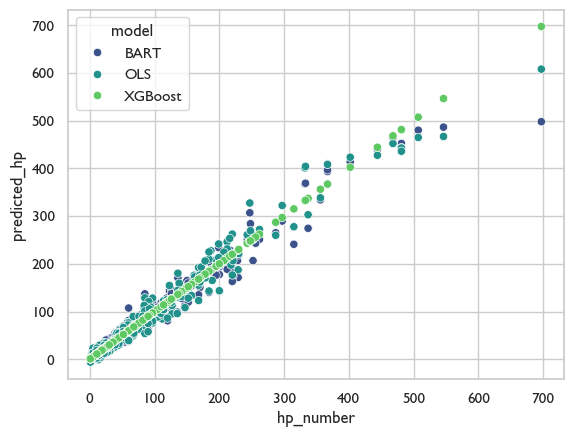

In [68]:
# Let's look at all of it together on one figure
sns.scatterplot(
    data=plot_df,
    x="hp_number", y="predicted_hp",
    hue="model"
    , palette="viridis"
)

Friday addendum: someone asked about comparing model performance based on test-train splits. I don't actually think this is necessary for exploratory analysis and where you're looking at fit quality across models, but it is a way to understand model performance, so I copied some code from 311 project and adapted it below. 

In [69]:
# split the preprocessed data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y
, test_size=0.2
, random_state=5272025)

# OLS
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_ols).fit()
ols_preds = ols_model.predict(X_test_ols)


# XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
xgb_model = xgb.train({"objective": "reg:squarederror", "seed": 5272025}, dtrain, num_boost_round=100)
xgb_preds = xgb_model.predict(dtest)

# BART
with pm.Model() as bart_model:
    X_shared = pm.Data("X_shared", X_train)
    μ = BART("μ", X=X_shared, Y=y_train)
    σ = pm.HalfNormal("σ", sigma=1)
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=y_train)
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.95, random_seed=5272025)

with bart_model:
    pm.set_data({"X_shared": X_test})
    pp = pm.sample_posterior_predictive(trace, var_names=["μ"], random_seed=5272025)

# Extract predicted means for test set from posterior predictive samples
bart_preds = pp.posterior_predictive["μ"].mean(dim=("chain", "draw")).values



                                                                                                           
  Progress            Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━   0       0             0.00        0            0.00 draws/s     0:00:00   -:--:--    
  ━━━━━━━━━━━━━━━━━   0       0             0.00        0            0.00 draws/s     0:00:00   -:--:--    
                                                                                                           
  Progress            Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━   0       0             0.00        0            0.00 draws/s     0:00:00   -:--:--    
  ━━━━━━━━━━━━━━━━━   0     

In [70]:
# taken from some old school code
def model_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# compare models
results = [
    {"Model": "OLS", **model_metrics(y_test, ols_preds)},
    {"Model": "XGBoost", **model_metrics(y_test, xgb_preds)},
    {"Model": "BART", **model_metrics(y_test, bart_preds)}
]

# make a lil table
perf_table = pl.DataFrame(results).select([
    "Model",
    pl.col("MSE").round(2),
    pl.col("MAE").round(2),
    pl.col("R2").round(2)
])


perf_table

shape: (3, 4)
┌─────────┬────────┬───────┬──────┐
│ Model   ┆ MSE    ┆ MAE   ┆ R2   │
│ ---     ┆ ---    ┆ ---   ┆ ---  │
│ str     ┆ f64    ┆ f64   ┆ f64  │
╞═════════╪════════╪═══════╪══════╡
│ OLS     ┆ 327.58 ┆ 12.12 ┆ 0.95 │
│ XGBoost ┆ 269.06 ┆ 10.22 ┆ 0.96 │
│ BART    ┆ 214.48 ┆ 10.5  ┆ 0.97 │
└─────────┴────────┴───────┴──────┘